# `JaxILI` hands-on tutorial - SBI meeting CosmoStats - 29/02/2024

*Author: Sacha Guerrini*

In [2]:
%load_ext autoreload
%autoreload 2

#Import utils
import os
import time
from tqdm import tqdm
from typing import Any

#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from chainconsumer import ChainConsumer
import optuna
import emcee

import sbibm

#Import torch useful libraries
import torch
import torch.utils.data as data

#Import from flowMC
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

#Import scripts from jaxili
from jaxili.utils import create_data_loader
from jaxili.model import ConditionalRealNVP, ConditionalMAF, MixtureDensityNetwork
from jaxili.train import TrainerModule

The goal of this notebook is to introduce Implicit-Likelihood Inference framework on simple example and showcase how `JaxILI` code works on those use cases.

**Setup:**

TBD

Implicit-Likelihood Inference, or equivalently Simulation-Based Inference/Likelihood-Free Inference, allows one to perform inference using only a forward model. The latter allows, in practice, to sample from the likelihood $\sim p(x|\theta)$ where the parameters $\theta$ are drawn from a proposal $p(\theta)$.

<img src=../assets/sbi.png alt= “” width=800>

Those simulations can be used to sample from the posterior in various ways tackling issues such as the intractability of latent variables (See Figure below) or non-gaussianities in the likelihood that can't be taken into account in Likelihood-Base Inference approaches. In this notebook, we will explore the following techniques:

- The traditional approach for Likelihood-Free: Approximate Bayesian Computation (ABC)
- Neural Density Estimation ... TBD using JaxILI
- Validation?

The test cases are taken from `sbibm` library which offers benchmark experiments from *Lueckmann et al. (2021)*. The variety of experiments introduced in this library allow to study the strengths and weaknesses of the different algorithms w.r.t the 'complexity' of the target distribution.

<img src=../assets/likelihood.png alt= “” width=800>

### Setup `sbibm` environment

In [ ]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'lotka_volterra',
 'two_moons',
 'sir',
 'slcp',
 'gaussian_linear',
 'bernoulli_glm',
 'gaussian_linear_uniform',
 'slcp_distractors',
 'bernoulli_glm_raw']

In this notebook, the default studied task will be `two_moons`. Users are free to modify the task to explore the capabilities of the different algorithms.

In [ ]:
task = sbibm.get_task('two_moons') #Load the task
prior = task.get_prior() #Load the prior
simulator = task.get_simulator() #Load the simulator
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1)) #Reference_samples to empirically assess the performance of the algorithm
observation = jnp.array(task.get_observation(num_observation=1)) #Load an observation x
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten()) #Load the fiducial value of the parameters theta

dim_truth = truth.shape[0]
dim_obs = observation.shape[1]
print("Dimension of parameter space: ", dim_truth)
print("Dimension of the observations: ", dim_obs)

Dimension of parameter space:  2
Dimension of the observations:  2


The next few lines of code create train, validation and test sets to be used for Neural Density Estimation. The user is free to tune the number of simulations used in both set. The training, validation and test sets are handled using `DataLoader` class from `pytorch`.

In [ ]:
class SimulationDataset(data.Dataset):
    def __init__(self, num_points):
        super().__init__()
        self.thetas = prior(num_samples=num_points)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [ ]:
#Specify the size of the training, validation and test set
train_set_size = 20000
val_set_size = 2000
test_set_size = 5000

#Create the datasets
train_set = SimulationDataset(train_set_size)
val_set = SimulationDataset(val_set_size)
test_set = SimulationDataset(test_set_size)

#Specify the batch_size
batch_size = 128
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = 128
)

## Aproximate Bayesian Computation (ABC)

A first 'naïve' approach to estimate the posterior using the forward model is called Approximate Bayesian Computation (ABC). It's a standard acceptance-rejection algorithm. The forward model is used to sample from $x \sim p(x|\theta)$ for a given set of parameters $\theta$. The resulting observation $x$ can be compared to the true $x_{\rm obs}$ to accept the sample $\theta$ based on a criteria controlled by a distance and a threshold $\epsilon$. (See Figure below)

<img src=../assets/abc.png alt= “” width=800>

In what follows, we will use a simple MSE on the data points to compare the simulated observables to the real ones.

In [6]:
def mse(x, y):
    """
    Computes the mean squared error between x and y.
    """
    return jnp.sqrt(jnp.sum((x-y)**2, axis=1))

def mae(x, y):
    """
    Computes the mean absolute error between x and y.
    """
    return jnp.sum(jnp.abs(x-y), axis=1)

In [7]:
#Definition of an abc function
def abc(obs, prior, simulator, epsilon, distance_function, n_samples):
    """
    ABC algorithm.

    Parameters
    ----------
    obs : jnp.array
        The observed data.
    epsilon : float
        The threshold value.
    distance_function : callable
        The distance function.
    n_samples : int
        The number of samples to draw.
    """
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted samples", unit="samples")

    while len(samples) < n_samples:
        thetas = prior(num_samples=1)
        xs = simulator(thetas)
        thetas, xs = jnp.array(thetas), jnp.array(xs)

        distances = distance_function(xs, obs)
        total_attempts += 1

        if distances < epsilon:
            samples.append(thetas)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=acceptance_ratio)

    progress_bar.close()
    return jnp.concatenate(samples, axis=0)

In [8]:
epsilons = [0.05, 0.1, 0.5]
samples = []

for epsilon in epsilons:
    print(f"Running ABC with epsilon={epsilon}")
    start = time.time()
    abc_samples = abc(observation, prior, simulator, epsilon, distance_function=mse, n_samples=5000)
    end = time.time()

    print(f"ABC sampling time: {end-start: .2f} seconds.")

    samples.append(abc_samples)

Running ABC with epsilon=0.05


Accepted samples: 100%|██████████| 5000/5000 [16:20<00:00,  5.10samples/s, acceptance_ratio=0.00386]


ABC sampling time:  980.60 seconds.
Running ABC with epsilon=0.1


Accepted samples: 100%|██████████| 5000/5000 [04:13<00:00, 19.76samples/s, acceptance_ratio=0.0155]


ABC sampling time:  253.15 seconds.
Running ABC with epsilon=0.5


Accepted samples: 100%|██████████| 5000/5000 [00:20<00:00, 239.44samples/s, acceptance_ratio=0.282]


ABC sampling time:  20.98 seconds.


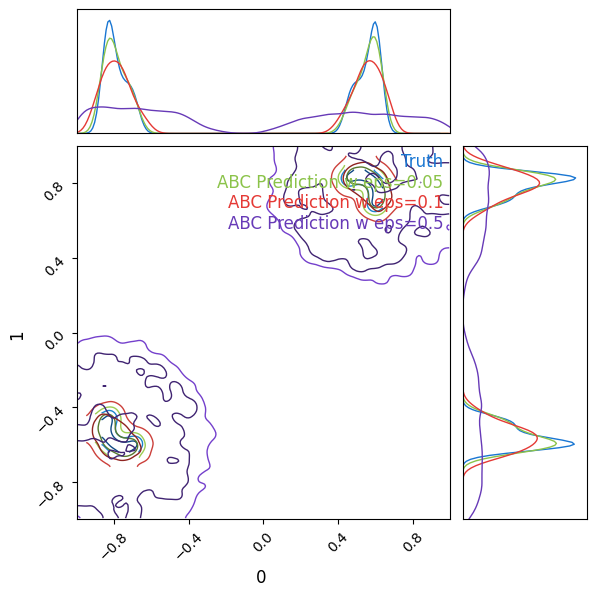

In [9]:
c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
for abc_samples, epsilon in zip(samples, epsilons):
    c.add_chain(abc_samples, shade_alpha = 0.5, name=f"ABC Prediction w eps={epsilon}")
fig = c.plotter.plot(figsize=2.)
plt.show()

In [11]:
for sample, epsilon in zip(samples, epsilons):
    np.save(f"samples/abc_samples_eps_mse_{epsilon}.npy", sample)

We can see empirically that the posterior is closer to the target the smaller $\epsilon$. We can also notice that the lower epsilon, the lower the acceptance rate. Hence, having a good estimate of the posterior requires a huge amount of calls to the simulator. In this case, this is no real problem. But in a real case, such as N-body simulations, one cannot afford so many simulations. The next sections will introduce Neural Density Estimators that allows to estimate the posterior using a neural network with a finite amount of simulations.

In [12]:
#Same run with mae
epsilons = [0.05, 0.1, 0.5]
samples = []

for epsilon in epsilons:
    print(f"Running ABC with epsilon={epsilon}")
    start = time.time()
    abc_samples = abc(observation, prior, simulator, epsilon, distance_function=mae, n_samples=5000)
    end = time.time()

    print(f"ABC sampling time: {end-start: .2f} seconds.")

    samples.append(abc_samples)

Running ABC with epsilon=0.05


Accepted samples: 100%|██████████| 5000/5000 [21:41<00:00,  3.84samples/s, acceptance_ratio=0.00247]


ABC sampling time:  1301.38 seconds.
Running ABC with epsilon=0.1


Accepted samples: 100%|██████████| 5000/5000 [05:25<00:00, 15.36samples/s, acceptance_ratio=0.0102]


ABC sampling time:  325.63 seconds.
Running ABC with epsilon=0.5


Accepted samples: 100%|██████████| 5000/5000 [00:23<00:00, 213.70samples/s, acceptance_ratio=0.202]


ABC sampling time:  23.52 seconds.


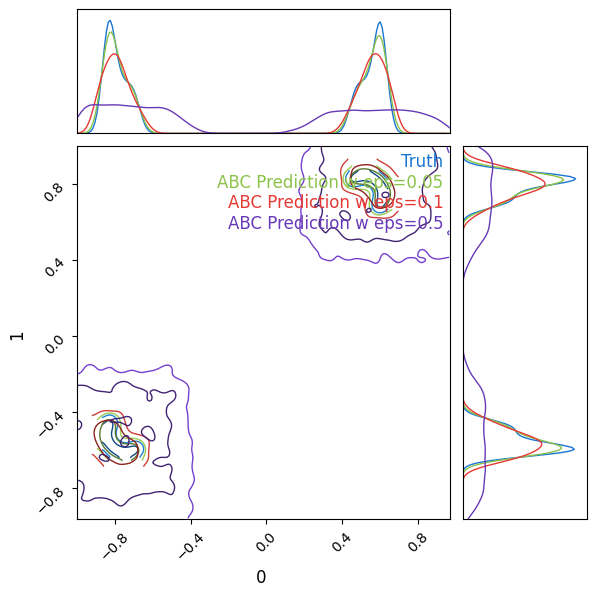

In [13]:
c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
for abc_samples, epsilon in zip(samples, epsilons):
    c.add_chain(abc_samples, shade_alpha = 0.5, name=f"ABC Prediction w eps={epsilon}")
fig = c.plotter.plot(figsize=2.)
plt.show()

In [14]:
for sample, epsilon in zip(samples, epsilons):
    np.save(f"samples/abc_samples_eps_mae_{epsilon}.npy", sample)

## Neural Density Estimation

Neural Density Estimation regroups technics allowing to sample from a posterior using neural networks. We can distinguish 3 main methods: Neural Posterior Estimation (NPE), Neural Likelihood Estimation and Neural Ratio Estimation.

<img src=../assets/NDE.png alt= “” width=800 height=300>

In what follows, TBD...

### Neural Posterior Estimation

We will first use Neural Posterior Estimation (NPE) to estimate the posterior $p(\theta|x)$. The principle is to use the simulator to sample pairs $(\theta, x) \sim p(x, \theta)$ from the joint probability distribution. We can then use Neural Network architectures such as Normalizing Flows (NFs) to estimate the posterior.

### Normalizing Flows

Normalizing Flows are invertible transformations of the probabilistic space that allows to map a simple distribution to a more complex distribution. (See figure below)

<img src=../assets/normalizingflows alt= “” width=800 height=300>

Neural Networks architectures exist to implement Normalizing Flows. `JaxILI` implements two of them as `NDENetwork` classes. This class implements two methods `log_prob` and `sample` that respectively allow to evaluate the log-probability of the target density and sample from the target density. The two available normalizing flows are the `ConditionalRealNVP` and the `ConditionalMAF` and can be found in the script `model.py`.

The script also includes a `MixtureDensityNetwork` that implements Mixture of Gaussians. The latter is not a Normalizing Flow but also allows to estimate probability distributions.

### Training a Neural Network to fit a probability distribution

So far, we have the tools to emulate a probability distribution with a neural network. We'll write such a probability distribution $p_{\varphi}$ where $\varphi$ are the parameters of the neural network. The goal of this section is to describe the optimization scheme used to train the neural network.

A way to measure how close two distributions are is by computing the Kullback-Leibler divergence:

$$
D_{\rm KL}(p||q) = \mathbb{E}_p\left[\log\left( \frac{p}{q}\right)\right]
$$

where $p$ and $q$ are probability distributions. The Kullback-Leibler divergence is not a distance since it's not symmetric. It is however positive and is equal to zero if and only if $p$ and $q$ are equal. Thus, a way to learn a probability $p$ with a neural network with weights $\varphi$ is to minimize $D_{\rm KL}(p||p_{\varphi})$ w.r.t the parameters $\varphi$. Let's do the math!

\begin{align*}
D_{\rm KL}(p||p_{\varphi})&=\mathbb{E}_p\left[\log\left(\frac{p}{p_{\varphi}}\right)\right]\\
&= \underbrace{\mathbb{E}_p[\log(p)]}_{-\text{Entropy of $p$}} - \mathbb{E}_p[\log(p_{\varphi})]\\
\end{align*}

Hence, minimizing the Kullback-Leibler divergence is equivalent to minimizing the negative log-likelihood since the entropy of $p$ does not depends on the NN parameters $\varphi$:

$$
\mathcal{L}_{\rm NLL} = \mathbb{E}_p[-\log(p_{\varphi})]
$$

The computation of the expectancy is possible in the framework of Simulation-Based inference because our simulator samples from the probability distribution $p$. The training set thus provides samples to approximate the loss:

$$
\mathcal{L}_{\rm NLL} = -\underset{i=1}{\overset{N_{\rm samples}}{\sum}}\log(p_{\varphi}(x_i))
$$

where $x_i$'s are samples from the probability distribution $p$.

In the context of Implicit Likelihood Inference, we will usually want to estimate joint distributions. It doesn't fundamentally changes the optimization scheme. Let's get to the code now!

### Training implementation

In this notebook, we will use `ConditionalRealNVP` as an example of architecture but the user is free to test other architectures. This architecture has 3 hyperparameters:

- The number of layers `n_layers` stacked in the RealNVP.
- The number and size of the hidden layers `layers`.
- The activation function `activation`.

To perform the training, we will build a class inheriting from `TrainerModule`. This class implements the whole training and validation loops. We only need to define our loss function as well as our train step. We lay the stress on the fact that the class methods can be overload if the user wants to modify the ay the training is done.

In [2]:
class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_layers : int,
                 layers : list[int],
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'n_in': n_in,
                             'n_layers': n_layers,
                             'layers' : layers,
                             'activation' : activation
                         },
                         **kwargs)
    
        self.trial=trial
        
    def create_functions(self): #Create the train_step and eval_step functions. This function is not implemented in the TrainerModule class.
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True, method='log_prob')
    
    def print_tabulate(self, exmp_input):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

NameError: name 'TrainerModule' is not defined

In [14]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto' #Specify the path where the checkpoints will be saved

trainer = RealNVPTrainer(n_in=dim_obs, #Dimension of the conditional
                         n_layers=4, 
                        layers=[128, 128],
                        activation = 'silu',
                        optimizer_hparams={'lr': 4e-3}, #Optimizer hyperparameters
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)), #Example of the input
                        check_val_every_epoch=5, #Number of epochs before checking the validation.
                        seed=0)

Missing logger folder: ~/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/ConditionalRealNVP/


We're all set. It is now as simple as typing `.train` to optimize the weights of your neural network. Metrics values are saved on the fly and can be checked during training and the best fit weights of the neural network are saved in checkpoints.

In [15]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [16]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.308178663253784
Validation loss: -3.333005905151367
Test loss: -3.3075411319732666


We see that the training, validation and test loss are in agreement. We thus avoided overfitting. Let's freeze our model and collect samples from the posterior:

In [17]:
model = trainer.bind_model()

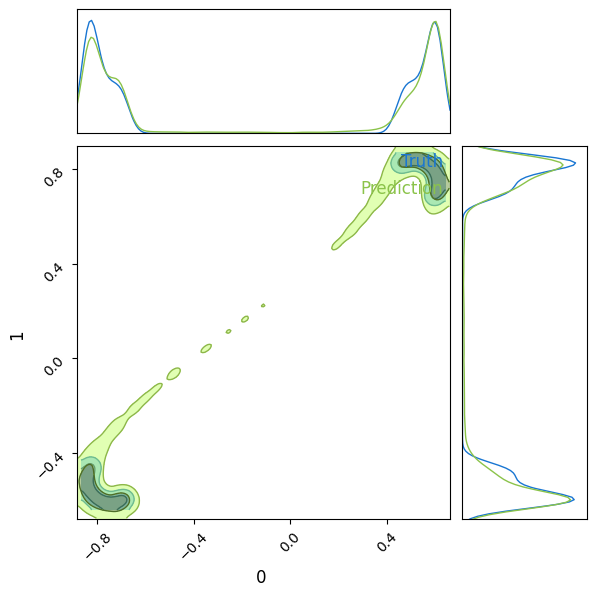

In [37]:
key = jax.random.PRNGKey(0) #Required to generate pseudo-random numbers in Jax
samples = model.sample(
    observation, num_samples=10000, key=key #The sample method allows to sample from the different output of the neural networks.
)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha=0.5, name='Truth')
c.add_chain(samples, shade_alpha=0.5, name='Prediction')
fig = c.plotter.plot(figsize=2.)
plt.show()

We see that the Normalizing Flow has been able to capture the bimodality of the target density and correctly covers the target density. We however observe a tail between the two regions of interest in the target density. This is expected since the normalizing flow is a continuous transformation that maps a unit gaussian to a bimodal distribution.

In the training, we fixed arbitrarily hyperparameters. It is though possible to optimize those using e.g. `Optuna`.

### Hyperparameter tuning with `Optuna`

In [16]:
#First specify the absolute checkpoint_path. Optuna does not like relative paths.
CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna'

We first need to create an `objective` function that takes a `trial` object in argument. This object will allow to test different hyperparameters values.

In [17]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loader(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = RealNVPTrainer(n_in=dim_obs, #Create your trainer
                            n_layers=trial.suggest_int('n_layers', 3, 10), #Try different number of layers
                            layers=[128, 128],
                            activation='silu',
                            optimizer_hparams={
                                  'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True) #Try different learning_rate
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(my_train_loader)), #beware of the training input.
                            check_val_every_epoch=5,
                            enable_progress_bar=False,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/loss']

In [18]:
#Let's go!
study = optuna.create_study(
    study_name='realnvp_slcp_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/optuna_hparam_search.db',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

[I 2024-02-24 22:02:33,258] Using an existing study with name 'realnvp_slcp_hparam_search' instead of creating a new one.
Missing logger folder: /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/
INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/version_0/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/version_0/checkpoint_5.orbax-checkpoint-tmp-1708808571728493 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/version_0/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_j

The computation can be lengthy so take a coffee or download the database containing the results. You can use `optuna-dashboard` on VSCode to access the results. Let's check the best hyperparameters!

In [19]:
trial = study.best_trial
print(f'Best Loss: {trial.value:.2f}')
print(f'Best hyperparameters:')
for key, value in trial.params.items():
    print(f' ->   {key}: {value}')

Best Loss: -3.67
Best hyperparameters:
 ->   n_layers: 7
 ->   lr: 0.009738239310805245


In [21]:
trainer = RealNVPTrainer.load_from_checkpoints(os.path.join(CHECKPOINT_PATH, 'ConditionalRealNVP/version_13/'),
                                               exmp_input=next(iter(train_loader)))
test_metrics = trainer.eval_model(test_loader)
print(f'Test accuracy: {test_metrics["loss"]:.2f}')

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/version_13/checkpoint_195
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/version_13/checkpoint_195.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna/ConditionalRealNVP/version_13/checkpoint_195.


Test accuracy: -3.66


In [22]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'n_layers'])
fig.show()

From this plot, we can learn 2 things:
- If the learning rate is too low, the optimization scheme struggles to find the minimum and the fit is poorer.
- Increasing the number of layers stacked in the NF returns a lower value of the loss. However, using too many layers increase the computation time. One needs to find a trade-off between accuracy and computation time.

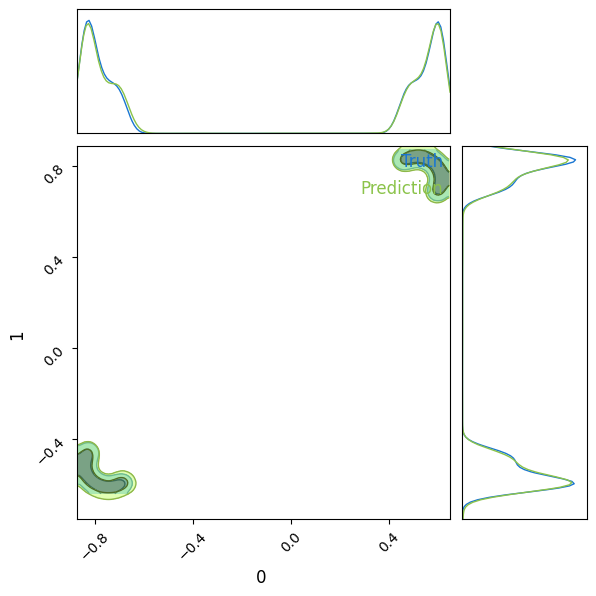

In [23]:
model = trainer.bind_model()

key = jax.random.PRNGKey(0)
samples = model.sample(
    observation, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha=0.5, name='Truth')
c.add_chain(samples, shade_alpha=0.5, name='Prediction')
fig = c.plotter.plot(figsize=2.)
plt.show()

We observe that the posterior obtained after finetuning the parameters performs better than the previous one. It is thus important to play with the different hyperparameters. We here focused only on the learning rate and the number of layers but one could also modify the number of epochs, the batch size, the activation function, etc...

## Neural Likelihood Estimation (NLE)

In what follows, we introduce Neural Likelihood Estimation (NLE), where rather than learning the posterior distribution, we learn the likelihood distribution $p(x|\theta)$. The procedure is the same than NPE but we swap the target and the conditional variables. This approach requires an additional sampling step to get the posterior.

In [6]:
class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_layers : int,
                 layers : list[int],
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'n_in': n_in,
                             'n_layers': n_layers,
                             'layers' : layers,
                             'activation' : activation
                         },
                         **kwargs)
    
        self.trial=trial
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, xs, thetas, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True, method='log_prob')
    
    def print_tabulate(self, exmp_input):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

In [7]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto'

trainer = RealNVPTrainer(n_in=dim_truth, #Dimension of the conditional
                         n_layers=4, 
                        layers=[128, 128],
                        activation = 'silu',
                        optimizer_hparams={'lr': 4e-3}, #Optimizer hyperparameters
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)), #Example of the input
                        check_val_every_epoch=5, #Number of epochs before checking the validation.
                        seed=0)

In [8]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [9]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -4.281561374664307
Validation loss: -4.271089553833008
Test loss: -4.279826641082764


In [10]:
model = trainer.bind_model()

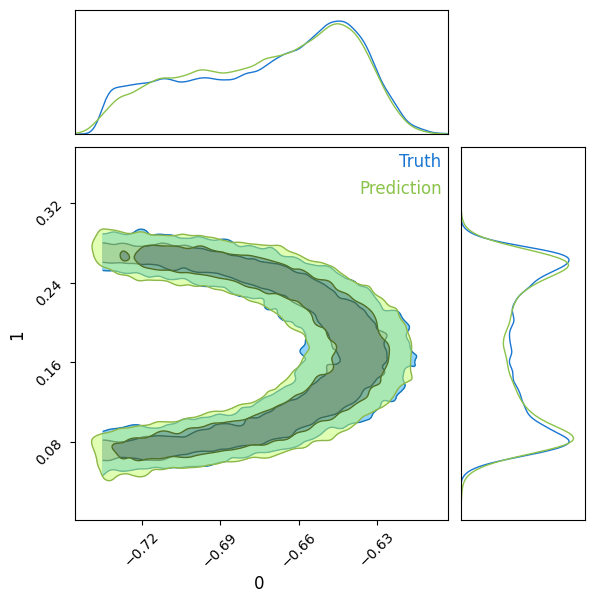

In [11]:
#Generate reference_samples from the likelihood using the simulator.
ll_reference_samples = jnp.array(simulator(torch.from_numpy(np.array(truth*jnp.ones((10000, 1))))))

key = jax.random.PRNGKey(0)
samples = model.sample(
    jnp.array([truth]), num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(ll_reference_samples, shade_alpha=0.5, name='Truth')
c.add_chain(samples, shade_alpha=0.5, name='Prediction')
fig = c.plotter.plot(figsize=2.)
plt.show()

Our neural network now emulates the likelihood. We can use it to compute the log-probability of the likelihood required as input of MCMC samplers.

We can use the library `emcee` to perform the inference.

In [24]:
def log_prob(theta, observation):
    log_prob = model.log_prob(observation.squeeze(), theta)
    return log_prob

jit_log_prob = jax.jit(log_prob)

In [29]:
%timeit log_prob(truth, observation)

205 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit jax.jit(log_prob)(truth, observation)

265 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Note here that using a jitted function increases the computation time by 3 orders of magnitude! And we're only working on CPU here.

In [100]:
def log_prior(theta):
    theta_0, theta_1 = theta
    if -1<theta_0<1 and -1<theta_1<1:
        return 0
    return -jnp.inf

def emcee_log_prob(theta, observation):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return np.array(jit_log_prob(theta, observation))

In [105]:
init = 0.5 * np.random.randn(32, 2)
nwalkers, ndim = init.shape
obs_reshape = np.array(observation*jnp.ones((nwalkers, 1)))

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, emcee_log_prob, args=(np.array(observation),)
)

sampler.run_mcmc(init, 20000, progress=True)

  0%|          | 0/20000 [00:00<?, ?it/s]/local/home/sg276684/anaconda3/envs/jax_sbi/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20000/20000 [00:20<00:00, 952.68it/s] 


State([[ 0.56622794  0.82551308]
 [-0.84192175 -0.5034757 ]
 [-0.82220868 -0.45624213]
 [ 0.61676151  0.72969069]
 [ 0.47059992  0.82642351]
 [-0.83317183 -0.56423802]
 [ 0.59869868  0.7906957 ]
 [ 0.58575111  0.79272781]
 [ 0.45864529  0.81591466]
 [-0.81697791 -0.47950756]
 [-0.66845384 -0.59007729]
 [-0.7144417  -0.62017852]
 [-0.83831687 -0.53659517]
 [-0.84052282 -0.49366668]
 [ 0.53870593  0.83488013]
 [ 0.61433664  0.72854237]
 [ 0.5921339   0.69788128]
 [-0.82922435 -0.43413221]
 [-0.72481919 -0.61243758]
 [-0.7142363  -0.59471303]
 [-0.69116561 -0.58622983]
 [-0.79628598 -0.59900363]
 [-0.75184279 -0.60102272]
 [ 0.59783747  0.75350486]
 [ 0.49965496  0.84482801]
 [-0.79253504 -0.59942556]
 [-0.80290117 -0.44634101]
 [ 0.51271022  0.85718383]
 [-0.78241463 -0.58760293]
 [ 0.60846291  0.78831013]
 [-0.83501385 -0.47313549]
 [-0.76627271 -0.60507916]], log_prob=[4.70775509 4.97314405 4.73104668 4.73969507 4.89284897 4.75011635
 4.71490955 4.13007069 4.60845041 3.60200548 3.87429

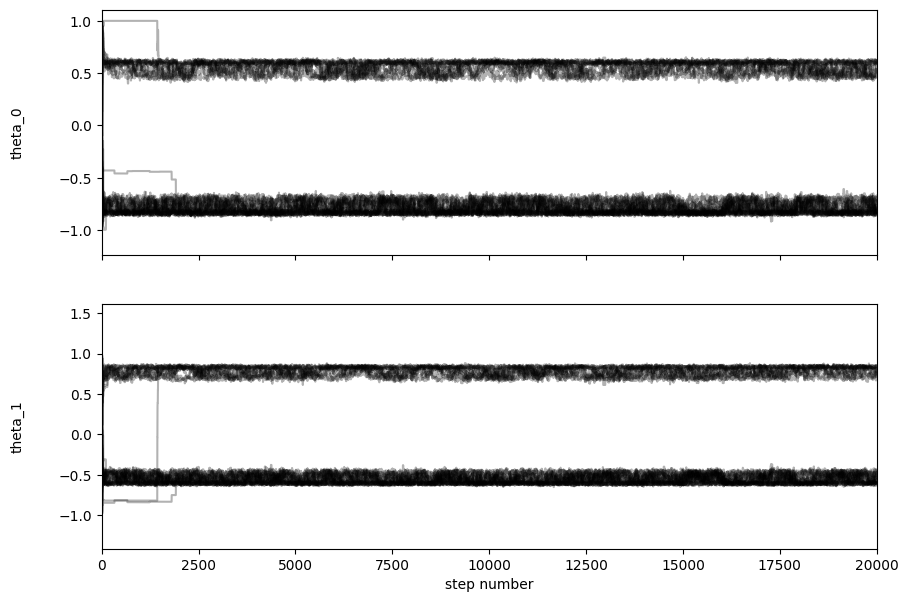

In [106]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["theta_0", "theta_1"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [107]:
flat_samples = sampler.get_chain(discard=5000, thin=50, flat=True)
print(flat_samples.shape)

(9600, 2)


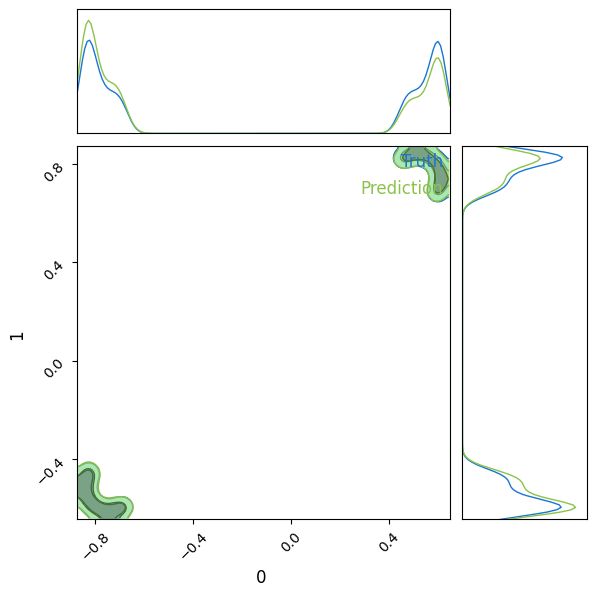

In [108]:
c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha=0.5, name='Truth')
c.add_chain(flat_samples, shade_alpha=0.5, name='Prediction')
fig = c.plotter.plot(figsize=2.)
plt.show()

We sse here than one of the drawback of the sampling step is that the quality of the samples depend on the sampler. Here `emcee` is bad at estimating such a bimodal distribution because the number of chains falling in each potential well is not the same.

We can tackle this issue using e.g `flowMC`.

In [122]:
n_chains = 32

rng_key_set = initialize_rng_keys(n_chains, seed=42)
initial_position = jax.random.normal(rng_key_set[0], (n_chains, dim_truth))*1
model = MaskedCouplingRQSpline(dim_truth, 3, [64, 64], 8, jax.random.PRNGKey(21))
step_size=1e-1
local_sampler = MALA(jit_log_prob, True, {"step_size": step_size})

nf_sampler = Sampler(
    dim_truth,
    rng_key_set, 
    jnp.arange(dim_truth),
    local_sampler,
    model,
    n_local_steps=100,
    n_global_steps=100,
    n_epochs=30,
    learning_rate=1e-2,
    batch_size=1000,
    n_chains = n_chains
)

nf_sampler.sample(initial_position, observation)
chains, log_probabilities, local_accs, global_accs = nf_sampler.get_sampler_state().values()

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/3 [00:00<?, ?it/s]

Compiling MALA body


Tuning global sampler: 100%|██████████| 3/3 [00:43<00:00, 14.36s/it]


Starting Production run


Production run: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


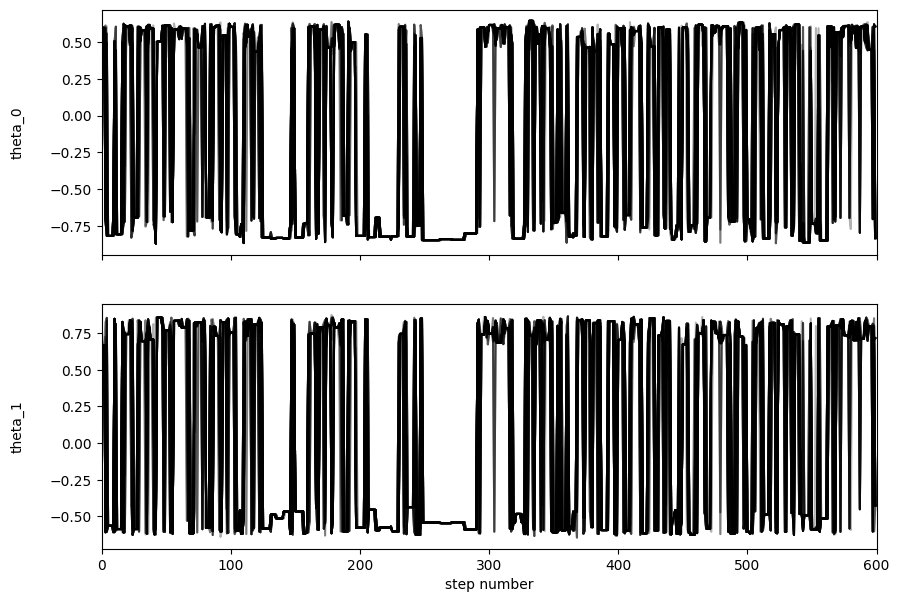

In [126]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = chains.reshape(-1, n_chains, dim_truth)
labels = ["theta_0", "theta_1"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

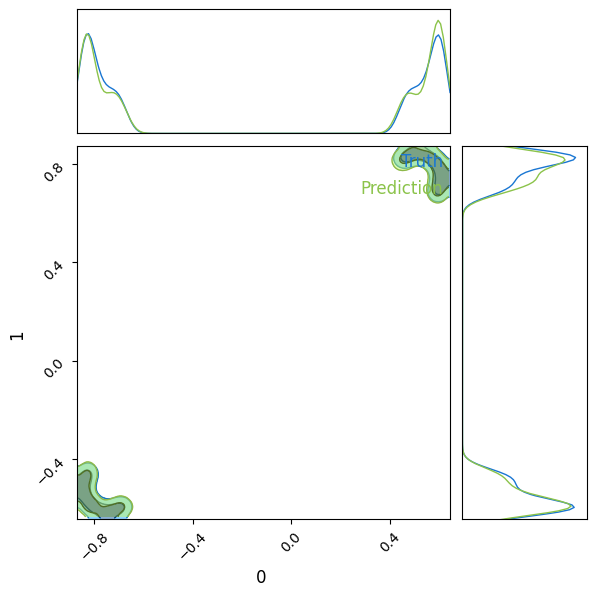

In [124]:
samples = chains.reshape(-1, 2)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha=0.5, name='Truth')
c.add_chain(samples, shade_alpha=0.5, name='Prediction')
fig = c.plotter.plot(figsize=2.)
plt.show()

## Validation - test of statistical coverage

An important step of the Implicit Likelihood Inference pipeline is the validation of the model if one wants to convince the community that the estimated posterior is valid. Let's first give some definitions.

The **Highest Posterior Density** interval is a region in the parameter space that contains the most probable values for a given credibility level $\alpha$. This is the shortest interval that contains the specified credibility level of the posterior distribution.

**Nominal covergae** is the probability of the proportion of the parameter space, that the HPD interval is intended to contain. If the nominal coverage is 0.95, the HPD interval should contain the true parameter value 95% of the time.

**Empirical coverage** is the proportion of true parameter values that actually fall within the HPD interval based on results of *simulations*

We will thus use our test set to perform such test. Let's load our previously trained NPE.

In [11]:
CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_tuto/optuna'

trainer = RealNVPTrainer.load_from_checkpoints(os.path.join(CHECKPOINT_PATH, 'ConditionalRealNVP/version_13/'),
                                               exmp_input=next(iter(train_loader)))
test_metrics = trainer.eval_model(test_loader)
print(f'Test accuracy: {test_metrics["loss"]:.2f}')

model = trainer.bind_model()

Test accuracy: -3.67


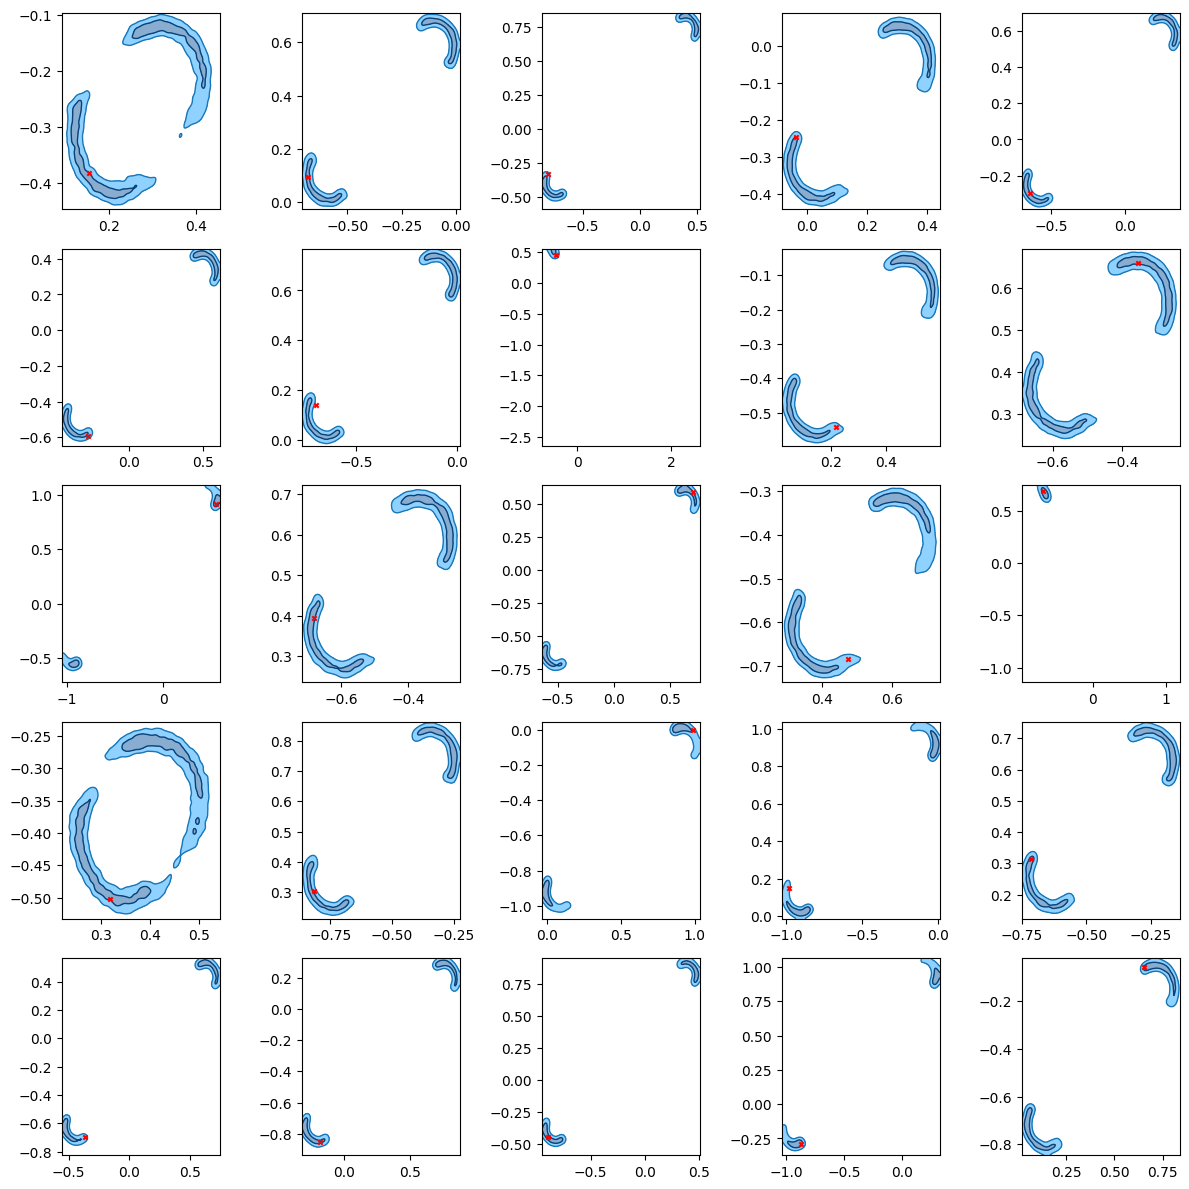

In [39]:
key = jax.random.PRNGKey(0)

fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.flatten()

for i in range(25):
    key, subkey = jax.random.split(key)
    theta, obs = test_set.__getitem__(i)
    samples = model.sample(jnp.array([obs]), num_samples=10000, key=subkey)

    c = ChainConsumer()
    c.add_chain(samples, shade_alpha=0.5, parameters=["\theta_0", "\theta_1"])
    c.configure(statistics="cumulative", sigma2d=[1, 2])

    c.plotter.plot_contour(ax[i], parameter_x="\theta_0", parameter_y="\theta_1")

    ax[i].scatter(theta[0], theta[1], c='r', s=10, marker='x')
fig.tight_layout()
plt.show()

In [ ]:
#Compute the Highest Posterior Density (HPD) interval
def hpd(samples, credible_mass=0.95):
    sorted_samples = jnp.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * len(sorted_samples)))
    n_intervals = sorted_samples.shape[0]- interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

